# Fine-Tuning EmbeddingGemma for Job Title Embeddings

This notebook demonstrates how to fine-tune Google's EmbeddingGemma model for generating high-quality embeddings of job titles. We'll use the Sentence Transformers library to adapt the model to our specific domain of job title similarity.

**Model Used:** [google/embeddinggemma-300M](https://huggingface.co/google/embeddinggemma-300M) on Hugging Face.

The process involves:
- Loading the pre-trained EmbeddingGemma model
- Preparing a dataset of job title triplets (anchor, positive, negative)
- Fine-tuning the model for better semantic similarity in job titles
- Evaluating and saving the fine-tuned model


## Prerequisites

Before running this notebook, ensure you have:
- Access to the EmbeddingGemma model on Hugging Face: [google/embeddinggemma-300M](https://huggingface.co/google/embeddinggemma-300M)
- A Hugging Face access token for authentication
- The generated job title triplets dataset (`title.csv` or `data.csv`)

This notebook is designed for both CPU and GPU environments.


## Setup Environment

Install the necessary libraries for working with EmbeddingGemma ([google/embeddinggemma-300M](https://huggingface.co/google/embeddinggemma-300M)) and Sentence Transformers. This includes the latest versions of sentence-transformers and transformers with EmbeddingGemma support.


### Install Required Packages

Run the following command to install sentence-transformers and the compatible transformers library for EmbeddingGemma.


In [ ]:
!pip install -U sentence-transformers git+https://github.com/huggingface/transformers@v4.56.0-Embedding-Gemma-preview

  Cloning https://github.com/huggingface/transformers (to revision v4.56.0-Embedding-Gemma-preview) to /tmp/pip-req-build-ce63qv_c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ce63qv_c
  Running command git checkout -q 60b68e304cf4b6569b0660a13b558b929d4b0e77
  Resolved https://github.com/huggingface/transformers to commit 60b68e304cf4b6569b0660a13b558b929d4b0e77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Authenticate with Hugging Face

To access the EmbeddingGemma model, you need to log in to Hugging Face with your access token. Replace the empty string with your token.


In [ ]:
# Login into Hugging Face Hub
from huggingface_hub import login
# from google.colab import userdata

login(token="")

/root/data/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load EmbeddingGemma Model

Initialize the SentenceTransformer model with the EmbeddingGemma-300M variant from Hugging Face: [google/embeddinggemma-300M](https://huggingface.co/google/embeddinggemma-300M). The model will be loaded on GPU if available, otherwise CPU.


In [ ]:
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "google/embeddinggemma-300M"
model = SentenceTransformer(model_id).to(device=device)

print(f"Device: {model.device}")
print(model)
print("Total number of parameters in the model:", sum([p.numel() for _, p in model.named_parameters()]))

Device: cuda:0
SentenceTransformer(
  (0): Transformer({'max_seq_length': 2048, 'do_lower_case': False, 'architecture': 'Gemma3TextModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 3072, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (3): Dense({'in_features': 3072, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (4): Normalize()
)
Total number of parameters in the model: 307581696


## Prepare Fine-Tuning Dataset

For fine-tuning, we use triplets of job titles: anchor (original), positive (similar meaning), and negative (same domain but different meaning). This teaches the model semantic similarity in the job title context.

We'll load our pre-generated dataset from `title.csv` (created using vLLM and job title data), clean it, and prepare it for training with a small evaluation split.


In [ ]:
import pandas as pd

df = pd.read_csv("title.csv")
df.head()

,Unnamed: 0,anchor,positive,negative
0,0,Growth Analyst,Someone who analyzes financial growth trends.,A teacher who instructs students in history.
1,1,Senior Brand Designer (Contract),Experienced Brand Designer needed on contract ...,Part-time Customer Service Representative requ...
2,2,Accounts Support Specialist,Customer Service Representative,Network Infrastructure Manager
3,3,Site Reliability Engineer,DevOps engineer focuses on reliability.,Marketing manager handles brand promotion.
4,4,Site Reliability Engineer,DevOps specialist works on system stability.,Marketing manager handles brand promotion stra...


In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,anchor,positive,negative
0,Growth Analyst,Someone who analyzes financial growth trends.,A teacher who instructs students in history.
1,Senior Brand Designer (Contract),Experienced Brand Designer needed on contract ...,Part-time Customer Service Representative requ...
2,Accounts Support Specialist,Customer Service Representative,Network Infrastructure Manager
3,Site Reliability Engineer,DevOps engineer focuses on reliability.,Marketing manager handles brand promotion.
4,Site Reliability Engineer,DevOps specialist works on system stability.,Marketing manager handles brand promotion stra...


In [ ]:
df.to_csv("data.csv", index=False)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 165.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 228.5 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 236.7 MB/s  0:00:00
  Attempting uninstall: fsspec0m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/22 [pyarrow]
    Found existing installation: fsspec 2026.1.0━━━━━━━━━━━━━━  3/22 [pyarrow]
    Uninstalling fsspec-2026.1.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/22 [pyarrow]
      Successfully uninstalled fsspec-2026.1.0━━━━━━━━━━━━━━━━  3/22 [pyarrow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22/22 [datasets]/22 [datasets]


In [ ]:
from datasets import load_dataset

# Load full training CSV
dataset = load_dataset(
    "csv",
    data_files="data.csv",
    split="train"
)

# Split 0.05% as evaluation
split = dataset.train_test_split(test_size=0.005)  # 0.05% = 0.0005 fraction

train_dataset = split["train"]
eval_dataset = split["test"]

print("Train size:", len(train_dataset))
print("Eval size:", len(eval_dataset))


Train size: 4975
Eval size: 25


## Evaluate Before Fine-Tuning

Test the base model's ability to distinguish similar job titles. We'll use the STS (Sentence Text Similarity) task prompt for optimal embeddings.

Example: Query a job title and see similarity scores with related and unrelated titles.


In [ ]:
task_name = "STS"

def get_scores(query, documents):
  # Calculate embeddings by calling model.encode()
  query_embeddings = model.encode(query, prompt_name=task_name)
  doc_embeddings = model.encode(documents, prompt_name=task_name)

  # Calculate the embedding similarities
  similarities = model.similarity(query_embeddings, doc_embeddings)

  for idx, doc in enumerate(documents):
    print("Document: ", doc, "-> 🤖 Score: ", similarities.numpy()[0][idx])

query = " Senior Brand Designer (Contract)"
documents = ["Experienced Brand Designer needed on contract basis.", " Part-time Customer Service Representative required."]

get_scores(query, documents)

Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.8901962
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.56286734


## Fine-Tune the Model

Configure and run the fine-tuning process using Sentence Transformers on the EmbeddingGemma model ([google/embeddinggemma-300M](https://huggingface.co/google/embeddinggemma-300M)). We'll use Multiple Negatives Ranking Loss to optimize for triplet similarity.

Training parameters include 5 epochs, batch size 64, and periodic evaluation. The model will learn to better differentiate job title semantics.


In [ ]:
from sentence_transformers import SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.losses import MultipleNegativesRankingLoss
from transformers import TrainerCallback

loss = MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="my-embedding-gemma",
    # Optional training parameters:
    prompts=model.prompts[task_name],    # use model's prompt to train
    num_train_epochs=5,
    per_device_train_batch_size=64,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    # Optional tracking/debugging parameters:
    logging_steps=100,
    eval_strategy="steps",        # Run evaluation periodically
    eval_steps=100,               # Evaluate every 100 steps
    save_strategy="steps",        # Save checkpoint every eval_steps
    save_steps=100,
    save_total_limit=2,           # Keep last 2 best checkpoints
    load_best_model_at_end=True,  # Automatically load the best model at the end
    metric_for_best_model="loss", # Use loss as the metric
    greater_is_better=False,      # Lower loss is better
    report_to="tensorboard",
)

class MyCallback(TrainerCallback):
    "A callback that evaluates the model at the end of eopch"
    def __init__(self, evaluate):
        self.evaluate = evaluate # evaluate function

    def on_log(self, args, state, control, **kwargs):
        # Evaluate the model using text generation
        print(f"Step {state.global_step} finished. Running evaluation:")
        self.evaluate()

def evaluate():
  get_scores(query, documents)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    callbacks=[MyCallback(evaluate)]
)
trainer.train()

Step,Training Loss,Validation Loss
100,0.564000,0.005692
200,0.279800,0.002878
300,0.191600,0.000985


Step 100 finished. Running evaluation:
Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.95273924
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.23714194
Step 100 finished. Running evaluation:
Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.95273924
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.23714194
Step 200 finished. Running evaluation:
Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.9635095
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.24319017
Step 200 finished. Running evaluation:
Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.9635095
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.24319017
Step 300 finished. Running evaluation:
Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.9473941
Document:   Part

The tokenizer you are loading from 'my-embedding-gemma/checkpoint-300' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Step 390 finished. Running evaluation:
Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.9473941
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.1442136


TrainOutput(global_step=390, training_loss=0.2968583180354192, metrics={'train_runtime': 138.5135, 'train_samples_per_second': 179.585, 'train_steps_per_second': 2.816, 'total_flos': 0.0, 'train_loss': 0.2968583180354192, 'epoch': 5.0})

In [ ]:
# !pip install -U transformers[torch] accelerate tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorboardX]


In [ ]:
# !tensorboard --logdir "my-embedding-gemma/runs"

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/default.py", line 39, in <module>
    from tensorboard.plugins.hparams import hparams_plugin
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/plugins/hparams/hparams_plugin.py", line 30, in <module>
    from tensorboard.plugins.hparams import backend_context
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/plugins/hparams/backend_context.py", line 24, in <module>
    from tensorboard.plugins.hparams import metadata
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/plugins/hparams/metadata.py", line 32, in <module>
    NULL_TENSOR = tensor_util.make_tensor_proto(
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/util/tensor_util.p

In [11]:
!pip install -U matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 210.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 205.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 157.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 218.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


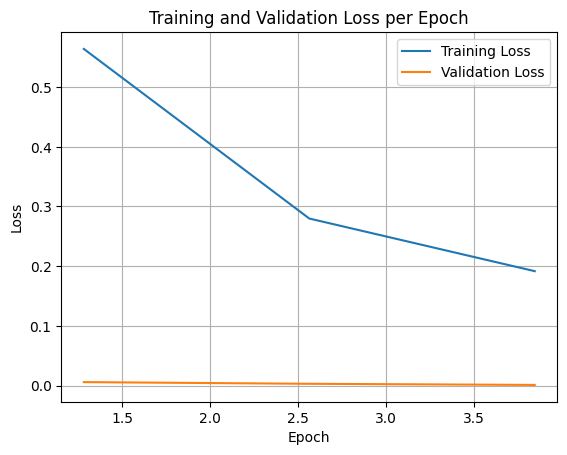

In [12]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Evaluate After Fine-Tuning

Re-run the similarity test with the fine-tuned model. The scores should show improved distinction between similar and dissimilar job titles.

Compare the before and after results to see the impact of fine-tuning.


In [13]:
get_scores(query, documents)

Document:  Experienced Brand Designer needed on contract basis. -> 🤖 Score:  0.9473941
Document:   Part-time Customer Service Representative required. -> 🤖 Score:  0.1442136


In [21]:
result = eval_dataset.to_list()

In [28]:
for i in result:
    score = get_scores(i['anchor'], [i["positive"], i["negative"]])
    print(score)

Document:  Experienced Developer Relations Specialist -> 🤖 Score:  0.8275244
Document:  Seasoned Database Administrator -> 🤖 Score:  0.015670165
None
Document:  Fundraising Manager position available -> 🤖 Score:  0.6805439
Document:  Software Engineer role opening -> 🤖 Score:  -0.17202617
None
Document:  Tester who ensures product quality through rigorous testing. -> 🤖 Score:  0.8165247
Document:  Software developer focusing on backend system integration. -> 🤖 Score:  0.058551494
None
Document:  Game developer focusing on role-playing games -> 🤖 Score:  0.80195653
Document:  Software tester specializing in mobile applications -> 🤖 Score:  0.07627922
None
Document:  Collaborators Teamup -> 🤖 Score:  0.92195666
Document:  Competitors Sign NonDisclosureAgreements -> 🤖 Score:  0.3417866
None
Document:  Hotel Receptionist duties include customer service and scheduling. -> 🤖 Score:  0.657133
Document:  Software Developer focuses on coding and programming languages. -> 🤖 Score:  -0.22202368
N

## Visualize Training Progress

Plot the training and validation loss curves to monitor the fine-tuning process and ensure convergence.


## Save and Upload Model

Save the fine-tuned model locally and optionally upload it to Hugging Face Hub for sharing and reuse.

The model can be loaded later for inference on new job title data.


### Upload to Hugging Face Hub

Use the `push_to_hub` method to upload your fine-tuned model. This makes it accessible to others and allows easy loading for future use.


In [26]:
# Push to Hub
model.push_to_hub("embedding-gemma-300m-job-titles")

Processing Files (4 / 4): 100%|██████████| 1.26GB / 1.26GB, 43.8MB/s  
New Data Upload: 100%|██████████|  776MB /  776MB, 43.8MB/s  


'https://huggingface.co/AROY76/embedding-gemma-300m-job-titles/commit/fc7f05bd77774ca7968cdc6eb66fe26de07bf299'

## Summary and Next Steps

You've successfully fine-tuned EmbeddingGemma for job title embeddings! The model now better understands semantic similarities in job titles.

Next steps:
- Use the fine-tuned model for job title matching, recommendations, or clustering
- Experiment with different hyperparameters or larger datasets
- Explore other embedding models for comparison

Model Link: [AROY76/embedding-gemma-300m-job-titles](https://huggingface.co/AROY76/embedding-gemma-300m-job-titles)

In [29]:
from sentence_transformers import SentenceTransformer

# Download from the 🤗 Hub
model = SentenceTransformer("AROY76/embedding-gemma-300m-job-titles")
# Run inference
queries = [
    "Dy. Manager - NPD Engineering",
]
documents = [
    'Lead Engineer for New Product Development',
    'Customer Service Representative',
    'Lead in expanding customer base.',
]
query_embeddings = model.encode_query(queries)
document_embeddings = model.encode_document(documents)
print(query_embeddings.shape, document_embeddings.shape)
# [1, 768] [3, 768]

# Get the similarity scores for the embeddings
similarities = model.similarity(query_embeddings, document_embeddings)
print(similarities)
# tensor([[ 0.4478, -0.1611,  0.0914]])


(1, 768) (3, 768)
tensor([[ 0.4478, -0.1611,  0.0914]])
